In [1]:
#To export data to Excel files
!pip install openpyxl

   -------------------------------------- 251.4/251.4 kB 909.9 kB/s eta 0:00:00


In [3]:
import pandas as pd

# Load the dataset
file_path = './waze.csv'
dataset = pd.read_csv(file_path)

# Clean the dataset by dropping rows with missing 'label'
dataset_cleaned = dataset.dropna(subset=['label']).copy()

# and removing the 'sessions' column (stay with the 'total_sessions')
dataset_cleaned = dataset_cleaned.drop(columns=['sessions'])

# dropping rows with "n_days_after_onboarding" (tatal) under 2 years
dataset_cleaned = dataset_cleaned[dataset_cleaned['n_days_after_onboarding'] > 730]

# dropping rows with "drives" (last month) equals to 0
dataset_cleaned = dataset_cleaned[dataset_cleaned['drives'] != 0]

# dropping rows with "total_sessions" (total) under 50
dataset_cleaned = dataset_cleaned[dataset_cleaned['total_sessions'] > 50]

# dropping rows with "total_navigations_fav1/2" (total) equals to 0
dataset_cleaned = dataset_cleaned[dataset_cleaned['total_navigations_fav1'] != 10]
dataset_cleaned = dataset_cleaned[dataset_cleaned['total_navigations_fav2'] != 10]

# dropping rows with "driven_km_drives" (total) under 200
dataset_cleaned = dataset_cleaned[dataset_cleaned['driven_km_drives'] > 200]

# dropping rows with "duration_minutes_drives" (last month) under 2 hours
dataset_cleaned = dataset_cleaned[dataset_cleaned['duration_minutes_drives'] > 120]

# dropping rows with "activity_days" (last month) equals to 0
dataset_cleaned = dataset_cleaned[dataset_cleaned['activity_days'] != 0]

# dropping rows with "driving_days" (last month) equals to 0
dataset_cleaned = dataset_cleaned[dataset_cleaned['driving_days'] != 0]

# Get the number of records
print(f"Number of records: {len(dataset_cleaned)}")

# Export to CSV
output_file_path = './cleaned_waze_app_dataset.csv'
dataset_cleaned.to_csv(output_file_path, index=False)
print(f"The cleaned dataset has been exported to {output_file_path}")

pd.DataFrame(dataset_cleaned).head(5)

Number of records: 9272
The cleaned dataset has been exported to ./cleaned_waze_app_dataset.csv


,ID,label,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
4,4,retained,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android
5,5,retained,103,279.544437,2637,0,0,901.238699,439.101397,15,11,iPhone


In [3]:
import networkx as nx

# Load the cleaned dataset
file_path = './cleaned_waze_app_dataset.csv'
dataset_cleaned = pd.read_csv(file_path)

# Split the dataset into iPhone and Android users
iphone_users = dataset_cleaned[dataset_cleaned['device'] == 'iPhone']
android_users = dataset_cleaned[dataset_cleaned['device'] == 'Android']
pd.DataFrame(iphone_users).head(5)
print(len(android_users))
print(len(iphone_users))


3335
5937


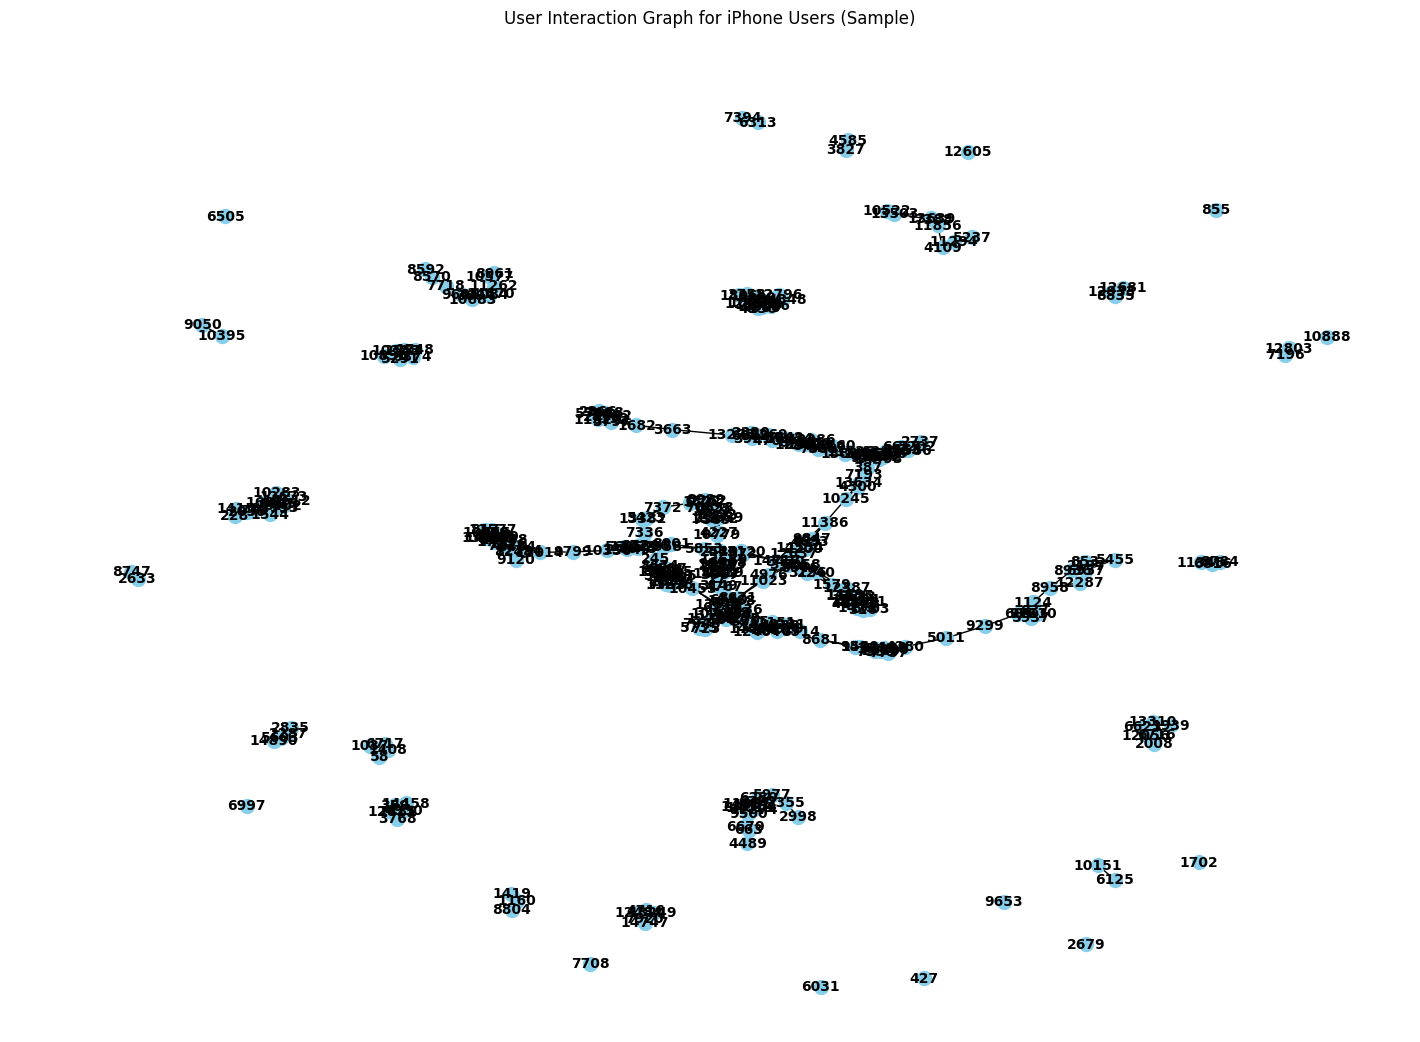

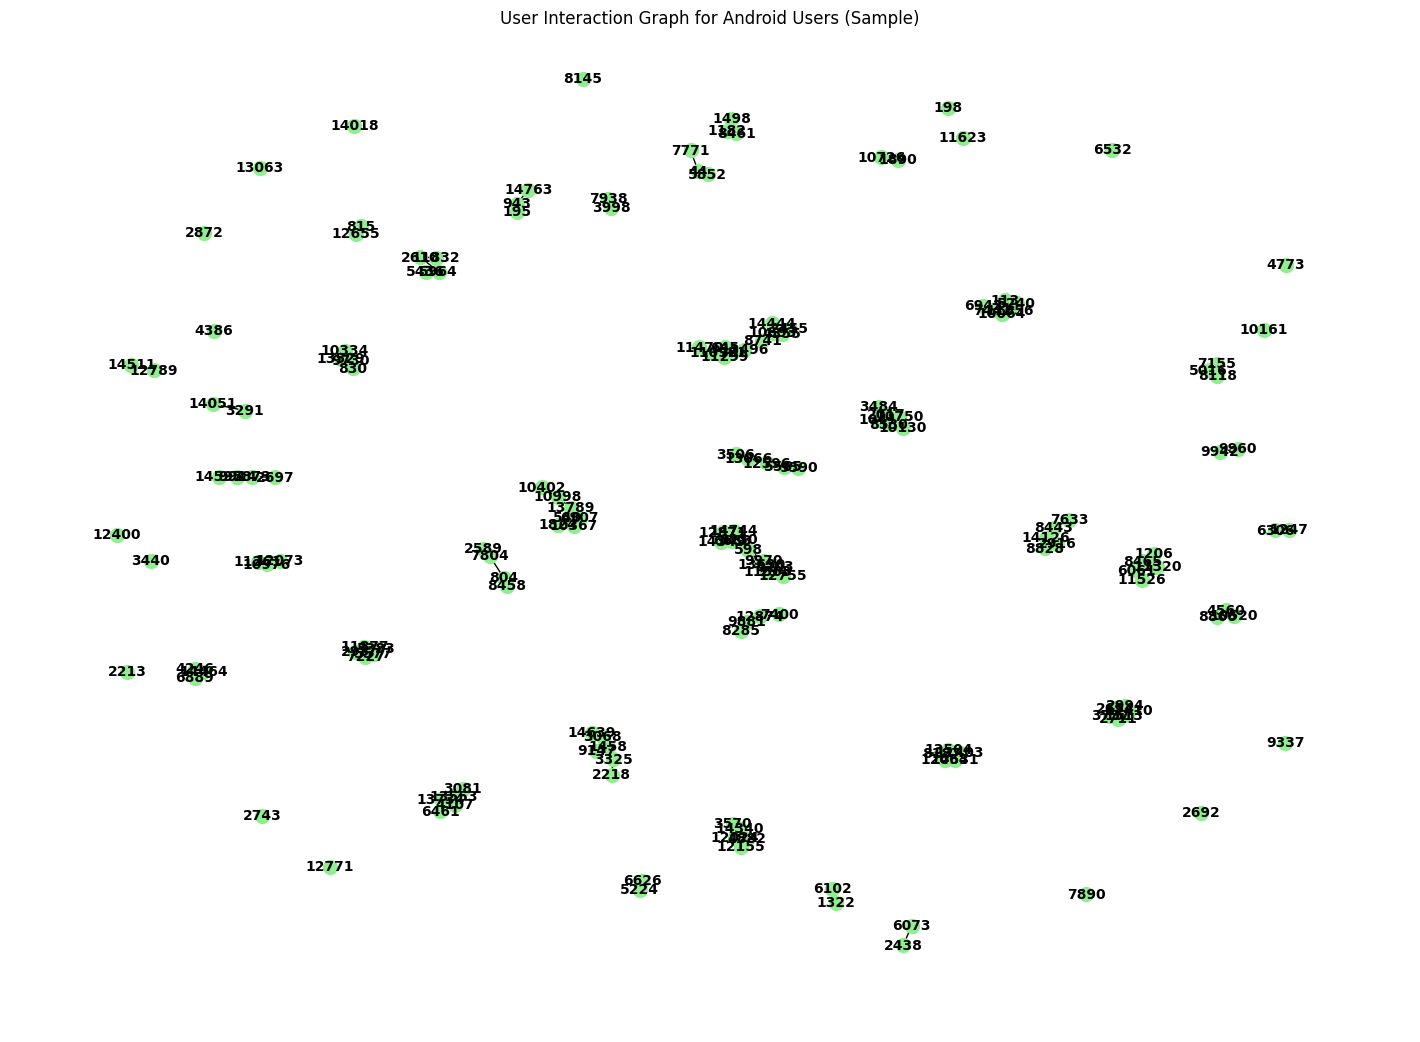

Communities in iPhone users graph: [[5, 27, 609, 1389, 1785, 1822, 1825, 2262, 2440, 2529, 2857, 3149, 3967, 4227, 4767, 5423, 5811, 5822, 6231, 6568, 6638, 6750, 7085, 7336, 7372, 7589, 8029, 8914, 8989, 9238, 9436, 10468, 10573, 10779, 11151, 13372, 13382, 13659, 13689, 14097, 14488], [58, 1037, 1408, 6717], [146, 245, 479, 605, 837, 853, 1067, 1124, 1541, 1621, 1677, 1744, 1834, 1943, 1999, 2197, 2950, 3382, 3464, 3877, 3915, 4258, 4280, 4648, 5011, 5455, 5515, 5906, 5937, 6244, 6508, 6957, 7350, 7610, 7757, 7828, 8517, 8674, 8681, 8902, 8936, 8958, 9113, 9299, 9520, 10199, 10455, 11298, 12287, 12464, 13195, 13512, 13707, 14404], [228, 776, 1415, 1544, 1683, 2050, 6475, 7933, 8379, 8402, 10283, 12673, 14612], [316, 372, 509, 817, 1376, 1469, 1473, 1579, 1709, 2003, 2240, 2558, 3058, 3196, 4724, 4851, 4859, 5583, 5696, 5853, 6703, 7122, 8045, 8119, 8248, 8484, 8646, 8815, 8901, 9120, 9799, 10055, 10356, 11155, 11273, 11538, 11577, 11811, 12104, 12387, 12794, 13014, 13049, 13112, 1312

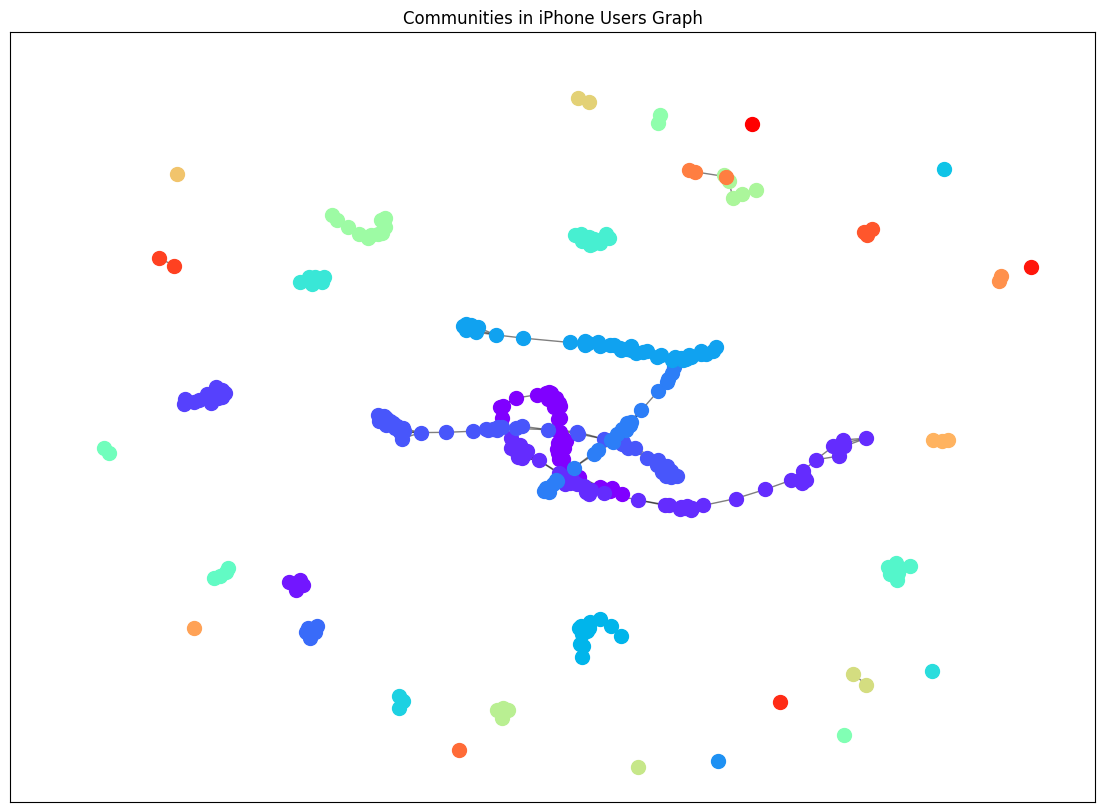

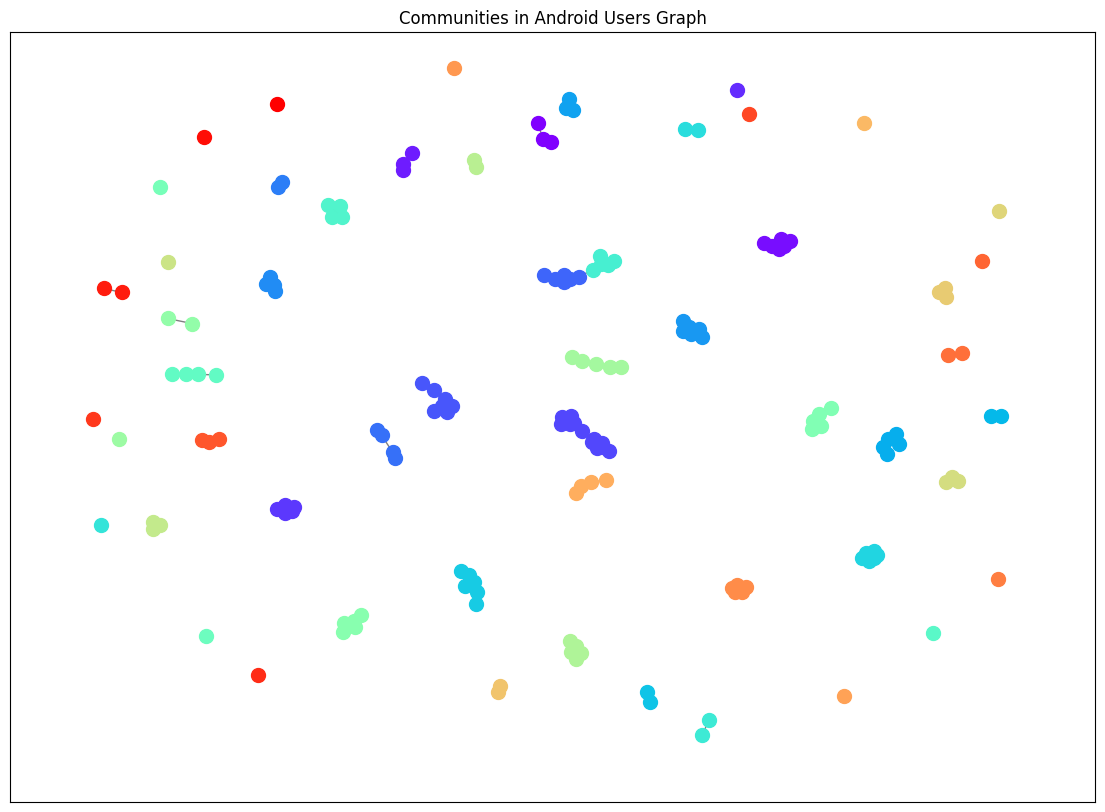

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = './cleaned_waze_app_dataset.csv'
dataset_cleaned = pd.read_csv(file_path)

# Take the first 500 rows of the dataset
dataset_sample = dataset_cleaned.head(500)

# Split the sample into iPhone and Android users
iphone_users_sample = dataset_sample[dataset_sample['device'] == 'iPhone']
android_users_sample = dataset_sample[dataset_sample['device'] == 'Android']

# Define a function to create a graph
def create_graph(users, threshold_km):
    G = nx.Graph()
    for idx, row in users.iterrows():
        G.add_node(row['ID'], total_sessions=row['total_sessions'], activity_days=row['activity_days'],
                   driven_km_drives=row['driven_km_drives'], duration_minutes_drives=row['duration_minutes_drives'],
                   device=row['device'], label=row['label'])
    for i, row1 in users.iterrows():
        for j, row2 in users.iterrows():
            if i < j and abs(row1['driven_km_drives'] - row2['driven_km_drives']) < threshold_km:
                G.add_edge(row1['ID'], row2['ID'], weight=abs(row1['driven_km_drives'] - row2['driven_km_drives']))
    return G

# Create graphs for iPhone and Android users in the sample
threshold_km = 5
G_iphone_sample = create_graph(iphone_users_sample, threshold_km)
G_android_sample = create_graph(android_users_sample, threshold_km)

# Define a function to draw the graph
def draw_graph(G, title, node_color):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=100, node_color=node_color, font_size=10, font_weight='bold')  # Increase node size
    plt.title(title)
    plt.show()

# Draw the graph for iPhone users
draw_graph(G_iphone_sample, 'User Interaction Graph for iPhone Users (Sample)', 'skyblue')

# Draw the graph for Android users
draw_graph(G_android_sample, 'User Interaction Graph for Android Users (Sample)', 'lightgreen')

# Function to detect communities using the Girvan-Newman algorithm
def detect_communities(G):
    communities = nx.community.girvan_newman(G)
    top_level_communities = next(communities)
    sorted_communities = sorted(map(sorted, top_level_communities))
    return sorted_communities

# Detect communities in the iPhone users graph
iphone_communities = detect_communities(G_iphone_sample)
print("Communities in iPhone users graph:", iphone_communities)

# Detect communities in the Android users graph
android_communities = detect_communities(G_android_sample)
print("Communities in Android users graph:", android_communities)

# Function to draw communities
def draw_communities(G, communities, title):
    plt.figure(figsize=(14, 10))  # Increase the figure size
    pos = nx.spring_layout(G, seed=42)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(communities)))
    for community, color in zip(communities, colors):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=[color], label=community, node_size=100)  # Increase node size
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(title)
    plt.show()

# Draw communities for iPhone users
draw_communities(G_iphone_sample, iphone_communities, 'Communities in iPhone Users Graph')

# Draw communities for Android users
draw_communities(G_android_sample, android_communities, 'Communities in Android Users Graph')

